In [ ]:
import pandas as pd
from pathlib import Path

players_path = Path("../data/raw/players.parquet")

df = pd.read_parquet(players_path, engine="pyarrow")

# Count unique players by player_id
unique_count = df["player_id"].nunique()

print(f"Total unique players: {unique_count}")


Total unique players: 2644


In [ ]:
import pandas as pd
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"

players = pd.read_parquet(DATA_PROCESSED / "players_clean_heights.parquet")

mean_height = players["height"].mean()
print("Average player height (meters):", round(mean_height, 2))
print("Average player height (cm):", round(mean_height * 100, 1))


Average player height (meters): 1.82
Average player height (cm): 182.2


پر کردن سلول های خالی با میانگین قد با تفکیک کردن جنسیت 

In [9]:
import pandas as pd
from pathlib import Path

# مسیرهای پروژه
PROJECT_ROOT = Path.cwd().parent
DATA_RAW = PROJECT_ROOT / "data" / "raw"
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"
DATA_PROCESSED.mkdir(parents=True, exist_ok=True)

# 1) بارگذاری فایل players از RAW
players = pd.read_parquet(DATA_RAW / "players.parquet")

# 2) میانگین قد قبل از پر کردن مقادیر خالی
print("Mean height BEFORE filling")
print(players.groupby("gender")["height"].mean())
print("Overall:", players["height"].mean())
print()

# 3) محاسبه میانگین قد برای هر جنسیت
gender_means = players.groupby("gender")["height"].mean()

# 4) ایجاد ستون جدید height_by_gender
players["height_by_gender"] = players["height"]

# 5) پر کردن NaN‌ها با میانگین قد همان جنسیت
for g, m in gender_means.items():
    players.loc[
        (players["gender"] == g) & (players["height_by_gender"].isna()),
        "height_by_gender"
    ] = m

# 6) ذخیره در PROCESSED
players.to_parquet(DATA_PROCESSED / "players_height_by_gender.parquet", index=False)
players.to_csv(DATA_PROCESSED / "players_height_by_gender.csv", index=False)

# 7) میانگین قد بعد از پر کردن مقادیر خالی
print("Mean height AFTER filling (height_by_gender)")
print(players.groupby("gender")["height_by_gender"].mean())
print("Overall:", players["height_by_gender"].mean())

# تفاوت میانگین کل بعد از پر کردن داده های نال نشون میده که
#  بیشتر داده های مربوط به زنان، ثبت نشده بود و با پر کردن اونها با میانگین قد از جنیست خودش
#  یک میانگین کل دقیقتر بدست میاریم که تعداد بالای زنان در اون تاثیر گذاشته
# پنج تا نال باقی موند که جنیست نداشتن و میشه با میانگین کشوری یا چیزای ترکیبی پرشون کرد


Mean height BEFORE filling
gender
F    1.731984
M    1.842860
Name: height, dtype: float64
Overall: 1.82169014084507

Mean height AFTER filling (height_by_gender)
gender
F    1.731984
M    1.842860
Name: height_by_gender, dtype: float64
Overall: 1.7909904885116341


Top 10 players by total wins:

In [10]:
import pandas as pd
from pathlib import Path

# Load from the new output location
input_file = Path("../data/raw/match_results_player.parquet")
df = pd.read_parquet(input_file)

# Rebuild "won" column from winner_code (1=home, 2=away)
df["won"] = ((df["side"] == "home") & (df["winner_code"] == 1)) | \
            ((df["side"] == "away") & (df["winner_code"] == 2))
df["won"] = df["won"].astype("boolean")

# Count total wins per player
wins = (
    df[df["won"]]
    .groupby(["player_id", "full_name"], as_index=False)
    .size()
    .rename(columns={"size": "wins"})
    .sort_values("wins", ascending=False)
    .reset_index(drop=True)
)

# Display top 10 players by total wins
print("Top 10 players by total wins:")
print(wins.head(10))

# Player with the most wins
top_player = wins.iloc[0]
print(f"\nPlayer with the most wins: {top_player['full_name']} ({top_player['wins']} wins)")


Top 10 players by total wins:
   player_id                          full_name  wins
0    50901.0                      Popko, Dmitry    29
1   231620.0                   Chidekh, Clement    22
2   202572.0                      Gengel, Marek    21
3   230049.0              Jianu, Filip Cristian    21
4    82133.0  Dellien Velasco, Murkel Alejandro    20
5   205282.0                  Kužmová, Katarína    19
6    58369.0                         Bolt, Alex    19
7   238867.0              Ovcharenko, Oleksandr    19
8   100093.0                 Ferrari, Francesco    18
9   186885.0                        Hardt, Nick    18

Player with the most wins: Popko, Dmitry (29 wins)


In [11]:
import pandas as pd
from pathlib import Path

# Path to the input parquet file
matches_path = Path("../data/processed/match_results_player_filled.parquet")

# Load the matches data
matches = pd.read_parquet(matches_path, engine="pyarrow")

# Total number of matches
print("Total matches:", len(matches))

# Matches with missing winner_code
missing_winner = matches[matches["winner_code"].isna()]
print("Missing winner:", len(missing_winner))

# Winner code distribution (including NaN)
print(matches["winner_code"].value_counts(dropna=False).head())


Total matches: 849506
Missing winner: 59229
winner_code
1.0    406699
2.0    383578
NaN     59229
Name: count, dtype: int64


Q10:  Is there a correlation between a player's height and their ranking? 

Pearson correlation coefficient: 0.107


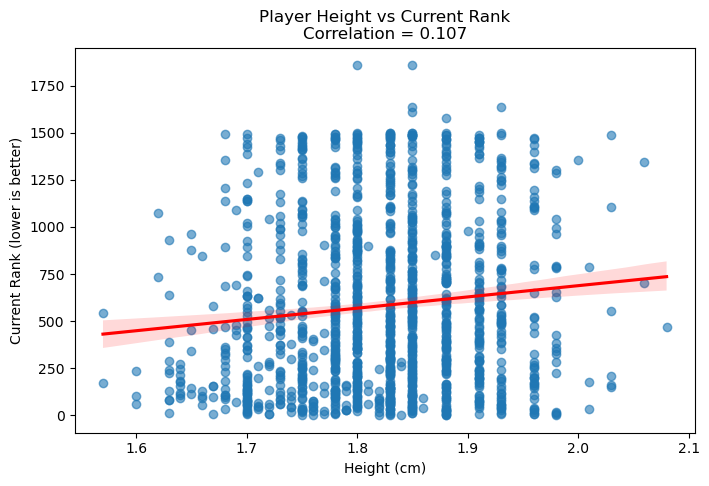

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

project_root = Path.cwd().parent

file_path = project_root / "data" / "processed" / "players_height_by_gender.parquet"

df = pd.read_parquet(file_path)

# حذف مقادیر NaN
data = df[['height', 'current_rank']].dropna()

# محاسبه همبستگی پیرسون
corr = data['height'].corr(data['current_rank'], method='pearson')
print(f"Pearson correlation coefficient: {corr:.3f}")

# رسم نمودار Scatter با خط روند
plt.figure(figsize=(8, 5))
sns.regplot(
    x='height',
    y='current_rank',
    data=data,
    scatter_kws={'alpha': 0.6},
    line_kws={'color': 'red'}
)
plt.title(f'Player Height vs Current Rank\nCorrelation = {corr:.3f}')
plt.xlabel("Height (cm)")
plt.ylabel("Current Rank (lower is better)")
plt.show()


In [13]:
import pandas as pd
from scipy.stats import pearsonr
from pathlib import Path

project_root = Path.cwd().parent

file_path = project_root / "data" / "processed" / "players_height_by_gender.parquet"

df = pd.read_parquet(file_path)

df = df.dropna(subset=["height", "current_rank"])

# محاسبه همبستگی پیرسون و p-value
r_value, p_value = pearsonr(df["height"], df["current_rank"])

print(f"Pearson correlation coefficient: {r_value:.3f}")
print(f"P-value: {p_value:.6f}")

# Pearson: میزان و جهت رابطه خطی
# P-value: معنی‌داری آماری این رابطه


Pearson correlation coefficient: 0.107
P-value: 0.000084


In [34]:
import pandas as pd
from pathlib import Path

project_root = Path.cwd().parent

file_path = project_root / "data" / "raw" / "players.parquet"

df = pd.read_parquet(file_path)

df_unique = df.drop_duplicates(subset="player_id")

col = "plays"

counts = df_unique[col].value_counts(dropna=True)

percentages = counts / counts.sum() * 100

nan_pct = df_unique[col].isna().mean() * 100

print("Unique players - Distribution of left vs right (non-missing values):")
print(counts)
print("\nPercentages:")
print(percentages.round(2))
print(f"\nNaN percentage in '{col}': {nan_pct:.2f}%")


Unique players - Distribution of left vs right (non-missing values):
plays
right-handed    1013
left-handed      133
Name: count, dtype: int64

Percentages:
plays
right-handed    88.39
left-handed     11.61
Name: count, dtype: float64

NaN percentage in 'plays': 56.66%


In [35]:
import pandas as pd
from pathlib import Path

project_root = Path.cwd().parent

file_path = project_root / "data" / "raw" / "match_results_player.parquet"

df = pd.read_parquet(file_path)

matches_per_player = df.groupby("player_id")["match_id"].nunique()

avg_matches = matches_per_player.mean()

max_matches = matches_per_player.max()
min_matches = matches_per_player.min()

print(f"Average matches per player: {avg_matches:.2f}")
print(f"Max matches for a player: {max_matches}")
print(f"Min matches for a player: {min_matches}")


Average matches per player: 9.11
Max matches for a player: 36
Min matches for a player: 1


Q6: Which country has produced the most successful tennis players? 


In [ ]:
import pandas as pd
from pathlib import Path

project_root = Path.cwd().parent

matches_file = project_root / "data" / "processed" / "match_results_with_winner.parquet"
players_file = project_root / "data" / "raw" / "players.parquet"

matches = pd.read_parquet(matches_file)
players = pd.read_parquet(players_file)

matches["winner_player_id"] = matches.apply(
    lambda row: row["home_player_id"] if row["winner_code"] == 1 else (
                row["away_player_id"] if row["winner_code"] == 2 else None),
    axis=1
)

matches = matches.dropna(subset=["winner_player_id"])

winners_with_country = matches.merge(
    players[["player_id", "country"]],
    left_on="winner_player_id",
    right_on="player_id",
    how="left"
)

country_win_counts = (
    winners_with_country
    .groupby("country")
    .size()
    .reset_index(name="wins")
    .sort_values(by="wins", ascending=False)
    .reset_index(drop=True)
)

country_win_counts.index = country_win_counts.index + 1
country_win_counts.index.name = "Rank"

print(country_win_counts.head(10))


             country  wins
Rank                      
1             France  1073
2              Italy   996
3                USA   944
4             Russia   671
5            Germany   563
6          Argentina   561
7              Japan   529
8              Spain   526
9          Australia   447
10    United Kingdom   379


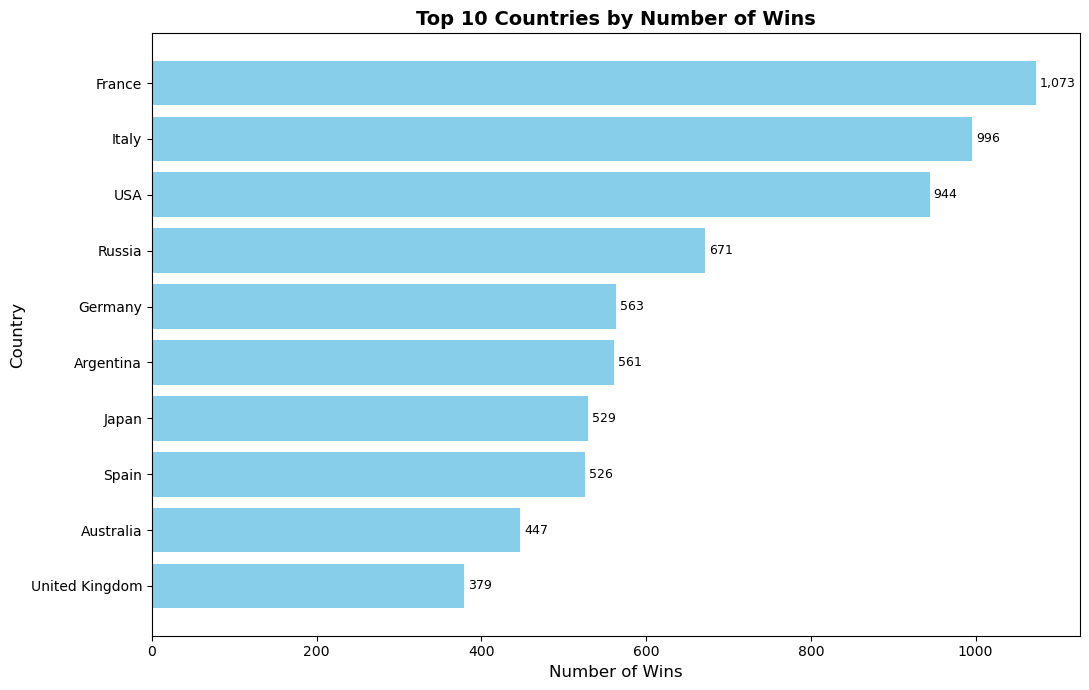

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

project_root = Path.cwd().parent

matches_file = project_root / "data" / "processed" / "match_results_with_winner.parquet"
players_file = project_root / "data" / "raw" / "players.parquet"

matches = pd.read_parquet(matches_file)
players = pd.read_parquet(players_file)

matches["winner_player_id"] = matches.apply(
    lambda row: row["home_player_id"] if row["winner_code"] == 1 else (
                row["away_player_id"] if row["winner_code"] == 2 else None),
    axis=1
)

matches = matches.dropna(subset=["winner_player_id"])

winners_with_country = matches.merge(
    players[["player_id", "country"]],
    left_on="winner_player_id",
    right_on="player_id",
    how="left"
)

country_win_counts = (
    winners_with_country
    .groupby("country")
    .size()
    .reset_index(name="wins")
    .sort_values(by="wins", ascending=False)
    .reset_index(drop=True)
)

top10 = country_win_counts.head(10)

plt.figure(figsize=(11, 7))
bars = plt.barh(top10["country"], top10["wins"], color="skyblue")
plt.xlabel("Number of Wins", fontsize=12)
plt.ylabel("Country", fontsize=12)
plt.title("Top 10 Countries by Number of Wins", fontsize=14, fontweight="bold")
plt.gca().invert_yaxis()

for bar in bars:
    width = bar.get_width()
    plt.text(width + 5, bar.get_y() + bar.get_height()/2,
             f"{width:,}", va='center', fontsize=9)

plt.tight_layout()
plt.show()


Question 15. How many distinct countries are represented in the dataset? 

In [25]:
import pandas as pd
from pathlib import Path

project_root = Path.cwd().parent

players_file = project_root / "data" / "raw" / "players.parquet"

players = pd.read_parquet(players_file)

countries = players["country"].dropna().unique()

# پرینت لیست کشورها
print("Unique countries:", sorted(countries))

distinct_count = len(countries)
print(f"\nTotal of {distinct_count} distinct countries are represented in the dataset.")


Unique countries: ['Algeria', 'Andorra', 'Antigua and Barbuda', 'Argentina', 'Australia', 'Austria', 'Bahamas', 'Barbados', 'Belarus', 'Belgium', 'Bolivia', 'Bosnia & Herzegovina', 'Brazil', 'Bulgaria', 'Burundi', 'Canada', 'Chile', 'China', 'Chinese Taipei', 'Colombia', 'Costa Rica', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Estonia', 'Finland', 'France', 'Georgia', 'Germany', 'Greece', 'Guadeloupe', 'Haiti', 'Hong Kong', 'Hungary', 'India', 'Indonesia', 'Iran', 'Ireland', 'Israel', 'Italy', 'Ivory Coast', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kosovo', 'Kyrgyzstan', 'Latvia', 'Lebanon', 'Liechtenstein', 'Lithuania', 'Luxembourg', 'Malaysia', 'Malta', 'Mexico', 'Moldova', 'Monaco', 'Morocco', 'Nepal', 'Netherlands', 'New Caledonia', 'New Zealand', 'Nigeria', 'North Macedonia', 'Norway', 'Pakistan', 'Paraguay', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Qatar', 'Romania', 'Russia', 'Senegal', 'Serbia', 'Singapor

In [ ]:
import pandas as pd
from pathlib import Path

project_root = Path.cwd().parent
matches_file = project_root / "data" / "processed" / "match_results_with_winner.parquet"
players_file = project_root / "data" / "raw" / "players.parquet"

matches = pd.read_parquet(matches_file)
players = pd.read_parquet(players_file)[["player_id", "full_name", "slug", "current_rank"]]

# ساخت ستون winner_player_id
matches["winner_player_id"] = matches.apply(
    lambda row: row["home_player_id"] if row["winner_code"] == 1 else row["away_player_id"],
    axis=1
)

matches["opponent_id"] = matches.apply(
    lambda row: row["away_player_id"] if row["winner_code"] == 1 else row["home_player_id"],
    axis=1
)

# rank
matches = matches.merge(
    players.rename(columns={
        "player_id": "opponent_id",
        "current_rank": "opp_rank"
    }),
    on="opponent_id",
    how="left"
)

top10_matches = matches[matches["opp_rank"] <= 10]

wins_count = top10_matches.groupby("winner_player_id").size().reset_index(name="wins_vs_top10")

result = wins_count.merge(players, left_on="winner_player_id", right_on="player_id")

top_player = result.sort_values("wins_vs_top10", ascending=False).head(1)
print(top_player[["full_name", "slug", "wins_vs_top10"]])


       full_name         slug  wins_vs_top10
30  Humbert, Ugo  humbert-ugo              4


Q9: Player with most tournament wins in each month: 

In [ ]:
import pandas as pd
from pathlib import Path

project_root = Path.cwd().parent
processed_dir = project_root / "data" / "processed"
raw_dir = project_root / "data" / "raw"

processed_dir.mkdir(parents=True, exist_ok=True)

players_file_processed = processed_dir / "players.parquet"
players_file_raw = raw_dir / "players.parquet"

if not players_file_processed.exists():
    if players_file_raw.exists():
        df_players_raw = pd.read_parquet(players_file_raw)
        df_players_raw.to_parquet(players_file_processed, index=False)
        print(f"Copied players.parquet from raw to processed: {players_file_processed}")


df_feb = pd.read_parquet(processed_dir / "match_round_info_february.parquet")
df_mar = pd.read_parquet(processed_dir / "match_round_info_march.parquet")
df_results = pd.read_parquet(processed_dir / "match_results_player_filled.parquet")
df_players = pd.read_parquet(players_file_processed)

df_feb["month"] = "February"
df_mar["month"] = "March"

df_rounds = pd.concat([df_feb, df_mar], ignore_index=True)

df_finals = df_rounds[df_rounds["cup_round_type"] == 1.0]

df_merged = df_finals.merge(df_results, on="match_id", how="inner")

def get_winner(row):
    if row["winner_code"] == 1:
        return row["home_player_id"]
    elif row["winner_code"] == 2:
        return row["away_player_id"]
    return None

df_merged["winner_player_id"] = df_merged.apply(get_winner, axis=1)

winners_count = (
    df_merged[["month", "winner_player_id", "match_id"]]
    .drop_duplicates()
    .groupby(["month", "winner_player_id"])
    .size()
    .reset_index(name="titles_won")
)

idx = winners_count.groupby("month")["titles_won"].idxmax()
top_champions_per_month = winners_count.loc[idx].reset_index(drop=True)

top_champions_per_month = top_champions_per_month.merge(
    df_players[["player_id", "slug"]],
    left_on="winner_player_id",
    right_on="player_id",
    how="left"
)

print(top_champions_per_month[["month", "winner_player_id", "slug", "titles_won"]])


      month  winner_player_id          slug  titles_won
0  February           50901.0  popko-dmitry           3
1     March          152766.0  helgo-malene           3


Most tournament wins in general:


In [ ]:
overall_winner = (
    winners_count.groupby("winner_player_id", as_index=False)["titles_won"]
    .sum()
    .sort_values(by="titles_won", ascending=False)
    .head(1)
    .merge(df_players[["player_id", "slug"]], left_on="winner_player_id", right_on="player_id", how="left")
)

print("\nTop champion overall (Feb + Mar):")
print(overall_winner[["winner_player_id", "slug", "titles_won"]])



Top champion overall (Feb + Mar):
   winner_player_id          slug  titles_won
0           50901.0  popko-dmitry           4


In [ ]:
import pandas as pd
from pathlib import Path

project_root = Path.cwd().parent
raw_dir = project_root / "data" / "raw" / "tennis_data"
processed_dir = project_root / "data" / "processed"

tourn_path = processed_dir / "tournaments_all_2024.parquet"

df_tourn = pd.read_parquet(tourn_path)
print("Before merge:", df_tourn.shape)

files = list(raw_dir.glob("2024*/MatchTournamentInfo.parquet"))
print(f"Found {len(files)} MatchTournamentInfo.parquet files")

dfs = []
for f in files:
    df_tmp = pd.read_parquet(f, columns=["match_id", "ground_type"])
    dfs.append(df_tmp)
df_ground = pd.concat(dfs, ignore_index=True).drop_duplicates(subset=["match_id"])

df_merged = df_tourn.merge(df_ground, on="match_id", how="left")

df_merged.to_parquet(tourn_path, index=False)
print("After merge:", df_merged.shape)
print("Sample with ground_type:")
print(df_merged.head())


In [ ]:
from pathlib import Path
import pandas as pd

project_root = Path.cwd().parent
raw_dir = project_root / "data" / "raw" / "tennis_data"

files = list(raw_dir.glob("2024*/data/raw/raw_match_parquet/time_*.parquet"))
print(f"Found {len(files)} time_*.parquet files")

dfs = []
for f in files:
    try:
        df_tmp = pd.read_parquet(f)

        period_cols = [c for c in df_tmp.columns if c.startswith("period_")]
        keep_cols = ["match_id"] + period_cols
        df_tmp = df_tmp[keep_cols]
        dfs.append(df_tmp)
    except Exception as e:
        print(f"Error reading {f}: {e}")

df_periods = pd.concat(dfs, ignore_index=True)

print("Shape:", df_periods.shape)
print(df_periods.head())

out_dir = project_root / "data" / "processed"
out_dir.mkdir(parents=True, exist_ok=True)
df_periods.to_parquet(out_dir / "all_match_periods.parquet", index=False)
print(f"Saved to {out_dir / 'all_match_periods.parquet'}")


Found 35671 time_*.parquet files


In [ ]:
import pandas as pd
from pathlib import Path

project_root = Path.cwd().parent
proc_dir = project_root / "data" / "processed"

df = pd.read_parquet(proc_dir / "all_match_periods.parquet")

# Numeric conversion
period_cols = [c for c in df.columns if c.startswith("period_")]
for c in period_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0)

df["duration_sec"] = df[period_cols].sum(axis=1)

# Filter out zero durations
df = df[df["duration_sec"] > 0]

df["duration_min"] = df["duration_sec"] / 60

# Calculate mean
avg_minutes = df["duration_min"].mean()
print(f"Average match duration: {avg_minutes:.2f} minutes")

out_dir = project_root / "reports" / "answers"
out_dir.mkdir(parents=True, exist_ok=True)
pd.DataFrame({"average_duration_minutes": [avg_minutes]}).to_csv(
    out_dir / "q11_avg_duration.csv", index=False, encoding="utf-8-sig"
)
print(f"Saved to {out_dir / 'q11_avg_duration.csv'}")


Average match duration: 119.15 minutes
Saved to c:\Users\mit\Desktop\Final_Project\reports\answers\q11_avg_duration.csv


Q4: What is the longest match recorded in terms of duration? 


In [6]:
import pandas as pd
from pathlib import Path

project_root = Path.cwd().parent
proc_dir = project_root / "data" / "processed"
out_dir = project_root / "reports" / "answers"
out_dir.mkdir(parents=True, exist_ok=True)

df_periods = pd.read_parquet(proc_dir / "all_match_periods.parquet")
df_results = pd.read_parquet(proc_dir / "match_results_player_filled.parquet")

period_cols = [c for c in df_periods.columns if c.startswith("period_")]

for c in period_cols:
    df_periods[c] = pd.to_numeric(df_periods[c], errors="coerce").fillna(0)

# normalization
def normalize_row(row):
    total = row.sum()
    if total > 10000:         # milliseconds
        return row / 1000
    elif total < 300:         # minutes
        return row * 60
    else:                     # seconds
        return row

df_periods[period_cols] = df_periods[period_cols].apply(normalize_row, axis=1)

df_periods["duration_sec"] = df_periods[period_cols].sum(axis=1)
df_periods = df_periods[df_periods["duration_sec"] > 0]
df_periods["duration_min"] = df_periods["duration_sec"] / 60

# filter unrealistic times
df_periods = df_periods[df_periods["duration_min"] <= 600]

# find longest match
longest_id = df_periods.loc[df_periods["duration_min"].idxmax(), "match_id"]

df_longest = df_periods.merge(df_results, on="match_id", how="left")
df_longest = df_longest[df_longest["match_id"] == longest_id]

if "start_datetime" in df_longest.columns:
    df_longest["start_datetime_dt"] = pd.to_datetime(
        df_longest["start_datetime"], unit="s", errors="coerce"
    )

df_longest.to_csv(out_dir / "q4_longest_match.csv", index=False, encoding="utf-8-sig")

row = df_longest.iloc[0]
print("The longest valid match with player info:")
print("Match ID:", row["match_id"])
if "tournament_name" in row:
    print("Tournament:", row["tournament_name"])
if "start_datetime_dt" in row:
    print("Start time:", row["start_datetime_dt"])
print(f"Duration: {row['duration_min']:.2f} minutes "
      f"({int(row['duration_min']//60)}h {int(row['duration_min']%60)}m)")


The longest valid match with player info:
Match ID: 12102290
Start time: 2024-02-26 10:00:00
Duration: 274.00 minutes (4h 34m)
